In [ ]:
!gdown 1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A

Downloading...
From: https://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A
To: /content/dataset.zip
100% 1.13G/1.13G [00:15<00:00, 71.2MB/s]


In [ ]:
!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/val/no/531.npy  
  inflating: dataset/val/no/257.npy  
  inflating: dataset/val/no/243.npy  
  inflating: dataset/val/no/525.npy  
  inflating: dataset/val/no/1099.npy  
  inflating: dataset/val/no/1927.npy  
  inflating: dataset/val/no/1933.npy  
  inflating: dataset/val/no/519.npy  
  inflating: dataset/val/no/1066.npy  
  inflating: dataset/val/no/1700.npy  
  inflating: dataset/val/no/294.npy  
  inflating: dataset/val/no/2209.npy  
  inflating: dataset/val/no/280.npy  
  inflating: dataset/val/no/1714.npy  
  inflating: dataset/val/no/1072.npy  
  inflating: dataset/val/no/2235.npy  
  inflating: dataset/val/no/1728.npy  
  inflating: dataset/val/no/2221.npy  
  inflating: dataset/val/no/733.npy  
  inflating: dataset/val/no/727.npy  
  inflating: dataset/val/no/1502.npy  
  inflating: dataset/val/no/1264.npy  
  inflating: dataset/val/no/928.npy  
  inflating: dataset/val/no/1270.npy  
  inflating: dataset/va

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os


In [ ]:
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/val"

In [ ]:
train_dir_no = os.path.join(train_dir, "no")
train_dir_sphere = os.path.join(train_dir, "sphere")
train_dir_vort = os.path.join(train_dir, "vort")

val_dir_no = os.path.join(val_dir, "no")
val_dir_sphere = os.path.join(val_dir, "sphere")
val_dir_vort = os.path.join(val_dir, "vort")

In [ ]:
import numpy as np
from PIL import Image
import os

def convert_to_png(source_dir: str) -> int:
    """
    Converts the numpy arrays into PNG images and saves them into a specified directory.
    """
    target_dir = os.path.join(source_dir, "png")
    os.makedirs(target_dir, exist_ok=True)
    
    for filename in os.listdir(source_dir):
        if not filename.endswith(".npy"):
            continue
        
        try:
            data = np.load(os.path.join(source_dir, filename), allow_pickle=True)
            data = np.squeeze(data * 255.0, 0)
            image = Image.fromarray(data.astype(np.uint8)).convert("L")
            png_filename = filename[:-4] + ".png"
            image.save(os.path.join(target_dir, png_filename))
        except Exception as e:
            print(f"Failed to convert {filename}: {e}")
        
    return 1

In [ ]:
convert_to_png(train_dir_no)
convert_to_png(train_dir_sphere)
convert_to_png(train_dir_vort)

convert_to_png(val_dir_no)
convert_to_png(val_dir_sphere)
convert_to_png(val_dir_vort)

1

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

def prepare_image(img):
    """
    Converts an image to a numpy array and scales its pixel values to the range [0, 1].
    """
    img = np.array(img)
    img = img.astype('float32') / 255.0
    return img

training_data_generator = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[1, 0.5],
    preprocessing_function=prepare_image,
    dtype=None
)

train_generator = training_data_generator.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=128
)

validation_data_generator = ImageDataGenerator(preprocessing_function=prepare_image)

validation_generator = validation_data_generator.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=64
)

Found 30000 images belonging to 3 classes.
Found 7500 images belonging to 3 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2

# Create the InceptionResNetV2 model
base_model = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(150, 150, 3))

# Add a custom classifier
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)

219055592/219055592 [==============================] - 2s 0us/step


In [ ]:
# Compile the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy', "AUC", "Precision", "Recall"])

In [ ]:
#Callback
from keras.callbacks import ModelCheckpoint
#Automatically save the best weights for the model containg the best validation
#AuC score after each epoch.
checkpoint = ModelCheckpoint("/content/drive/MyDrive/GSOC2023",
                             monitor='val_auc', save_weights_only=True,
                             verbose=1, save_best_only=True, mode='max',
                             save_freq="epoch")

plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.1,
                                               patience=10, verbose=0,
                                               mode="max")

In [ ]:
# Train the model
history = model.fit(train_generator, epochs=10, batch_size=32, validation_data=validation_generator, callbacks=[checkpoint, plateau])

Epoch 1/10
235/235 [==============================] - ETA: 0s - loss: 1.1282 - accuracy: 0.3405 - auc: 0.5074 - precision: 0.3464 - recall: 0.0109
Epoch 1: val_auc improved from -inf to 0.55428, saving model to /content/drive/MyDrive/GSOC2023
235/235 [==============================] - 407s 1s/step - loss: 1.1282 - accuracy: 0.3405 - auc: 0.5074 - precision: 0.3464 - recall: 0.0109 - val_loss: 1.0825 - val_accuracy: 0.3715 - val_auc: 0.5543 - val_precision: 0.6512 - val_recall: 0.0149 - lr: 0.0010
Epoch 2/10
235/235 [==============================] - ETA: 0s - loss: 0.9470 - accuracy: 0.5059 - auc: 0.7185 - precision: 0.6172 - recall: 0.2673
Epoch 2: val_auc improved from 0.55428 to 0.69937, saving model to /content/drive/MyDrive/GSOC2023
235/235 [==============================] - 279s 1s/step - loss: 0.9470 - accuracy: 0.5059 - auc: 0.7185 - precision: 0.6172 - recall: 0.2673 - val_loss: 2.8167 - val_accuracy: 0.5041 - val_auc: 0.6994 - val_precision: 0.5125 - val_recall: 0.4823 - lr: 

In [ ]:
model.save("/content/drive/MyDrive/gsoc_task")

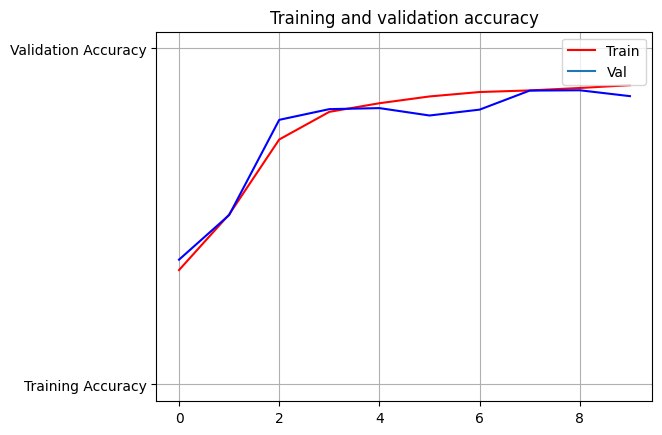

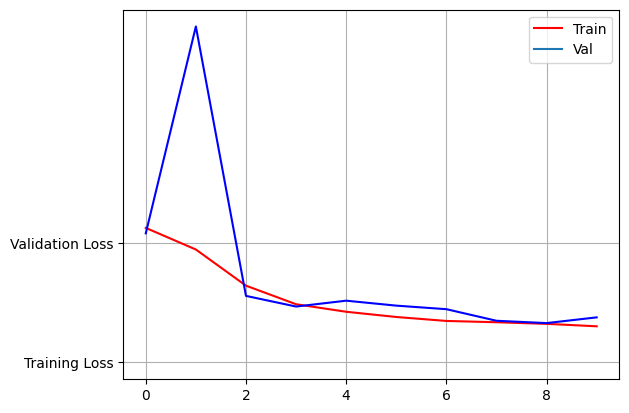

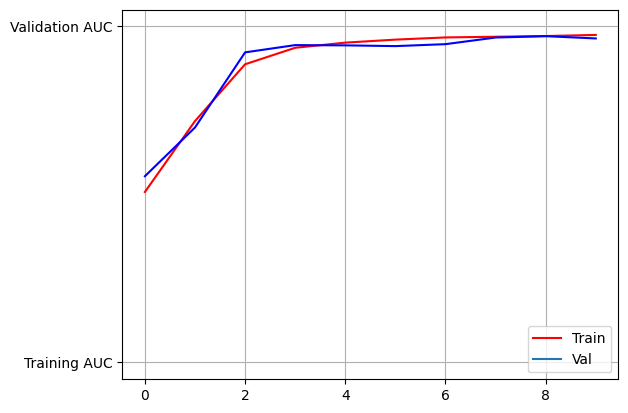

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
train_auc = history.history["auc"]
val_auc  = history.history["val_auc"]

epochs=range(len(acc)) # Get number of epochs


plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(["Train", "Val"])
plt.grid()
plt.show()
print("")


plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.legend(["Train", "Val"])
plt.grid()

plt.show()
print("")
plt.plot(epochs, train_auc, 'r', "Training AUC")
plt.plot(epochs, val_auc, 'b', "Validation AUC")
plt.legend(["Train", "Val"])
plt.grid()

plt.show()